In [1]:
###########################################
############ COMPLETED SEP 14, 2021 #######
###########################################
import pandas as pd
import SimpleITK as sitk
import seaborn as sea
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# time to export test set images...
import SimpleITK as sitk

In [3]:
import torch
from scipy.spatial.distance import directed_hausdorff as hausd
from typing import Optional
import torch.nn.functional as F

In [4]:
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance
from monai.metrics import compute_meandice

In [5]:
import glob
img = glob.glob('/Users/joemarsilla/wolnet_gtv/Test_WOLNET_2020_09_18_135329/*.npy')

In [7]:
img = img[3:]

In [8]:
img

['/Users/joemarsilla/wolnet_gtv/Test_WOLNET_2020_09_18_135329/in_0.npy',
 '/Users/joemarsilla/wolnet_gtv/Test_WOLNET_2020_09_18_135329/targ_0.npy',
 '/Users/joemarsilla/wolnet_gtv/Test_WOLNET_2020_09_18_135329/out_0.npy']

In [10]:
image = np.load(img[0])
targ = np.load(img[1])
out = np.load(img[2])

In [11]:
image.shape

(244, 1, 64, 192, 192)

In [23]:
targ.max()

1.0

In [24]:
out.max()

1.0

In [15]:
def onehot(outs, targ):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    batch = shape[0]
    # calculate argmax...
    # outputs = torch.argmax(outs, dim=1)
    class_ = torch.max(targ)
    print(class_)
    if len(shape) == 4:
        # 3D OUTPUT ARRAY HAS TO BE 5D IF ONE HOT ENCODED
        # see what you do when you initialize a new tensor
        # https://pytorch-lightning.readthedocs.io/en/latest/lightning-module.html
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        targets_dice = torch.zeros(sh, dtype=torch.float) # .type_as(outs)
        targets_out = torch.zeros(sh, dtype=torch.float) # .type_as(targ)
                                   # (batch, self.hparams.n_classes + 1,
                                   #                            self.hparams.window * 2,
                                   #                            self.hparams.crop_factor // 2,
                                   #                            self.hparams.crop_factor // 2)

    for i in range( class_ + 1):

        targets_dice[:, i][targ == i] = 1
        targets_out[:, i][outputs == i] = 1
    
    return targets_out, targets_dice

In [16]:
outputs = torch.from_numpy(out)
targets = torch.from_numpy(targ)

In [17]:
outputs.size()

torch.Size([244, 1, 64, 192, 192])

In [ ]:
data = {}
dices = []
hd = []
test_patient = []

In [29]:
hd = compute_hausdorff_distance(outputs, targets, percentile=95, include_background=True)
sd = compute_average_surface_distance(outputs, targets, include_background=True)
dce = compute_meandice(outputs, targets)

In [33]:
sd[22]

tensor([22.4733], dtype=torch.float64)

In [58]:
print(dce.argmax(), dce.argmin())

tensor(175) tensor(54)


In [59]:
print(hd.argmax(), hd.argmin())

tensor(22) tensor(41)


In [60]:
print(sd.argmax(), sd.argmin())

tensor(161) tensor(205)


In [36]:
hd[41]

tensor([1.4142], dtype=torch.float64)

In [37]:
dce[41]

tensor([0.7747])

In [38]:
hd[175]

tensor([3.3166], dtype=torch.float64)

In [39]:
dce[175]

tensor([0.8867])

In [41]:
import seaborn as sea

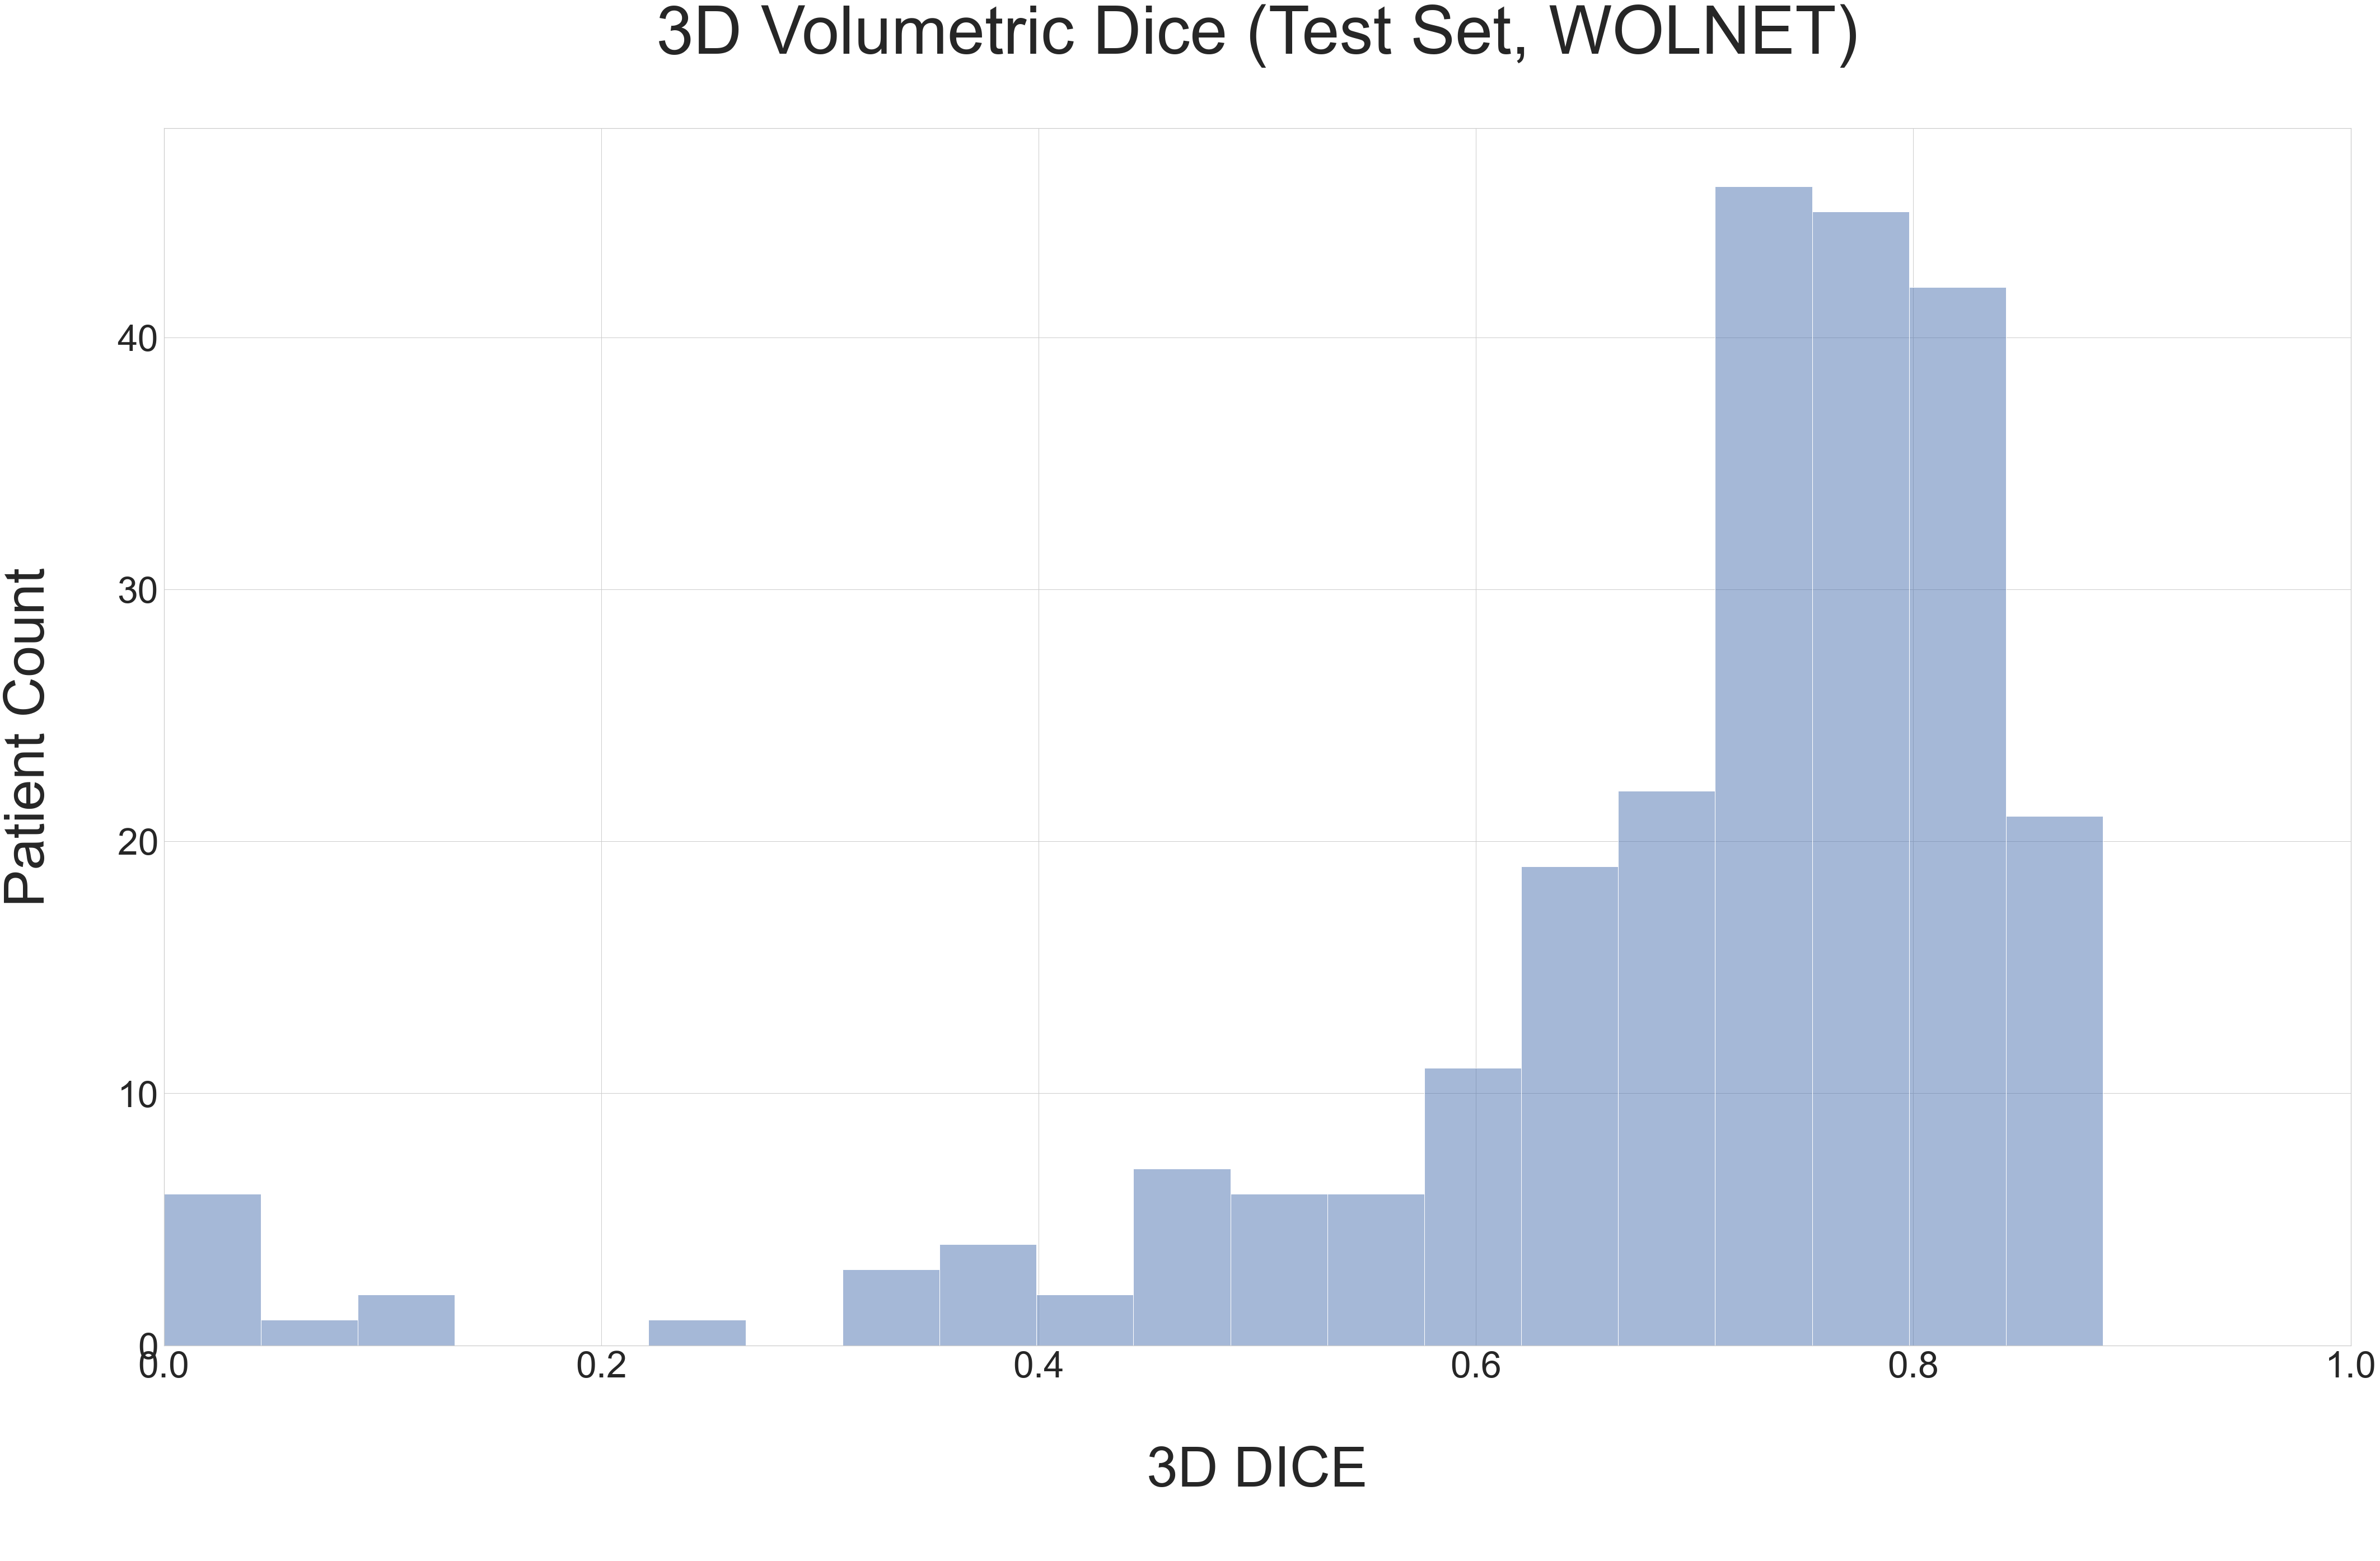

In [102]:
plt.figure(figsize=(70,40))
sea.set(font_scale=6)  # crazy big
sea.set_style("whitegrid")
# sea.color_palette("Spectral", as_cmap=True)
ax = sea.histplot(dce.numpy())
plt.title('3D Volumetric Dice (Test Set, WOLNET)\n', fontsize=120)
ax.set_xlabel('\n3D DICE\n', fontsize=100)
ax.set_ylabel('Patient Count\n', fontsize=100)
ax.set_xlim(0., 1.)
ax.legend_.remove()

AttributeError: 'NoneType' object has no attribute 'remove'

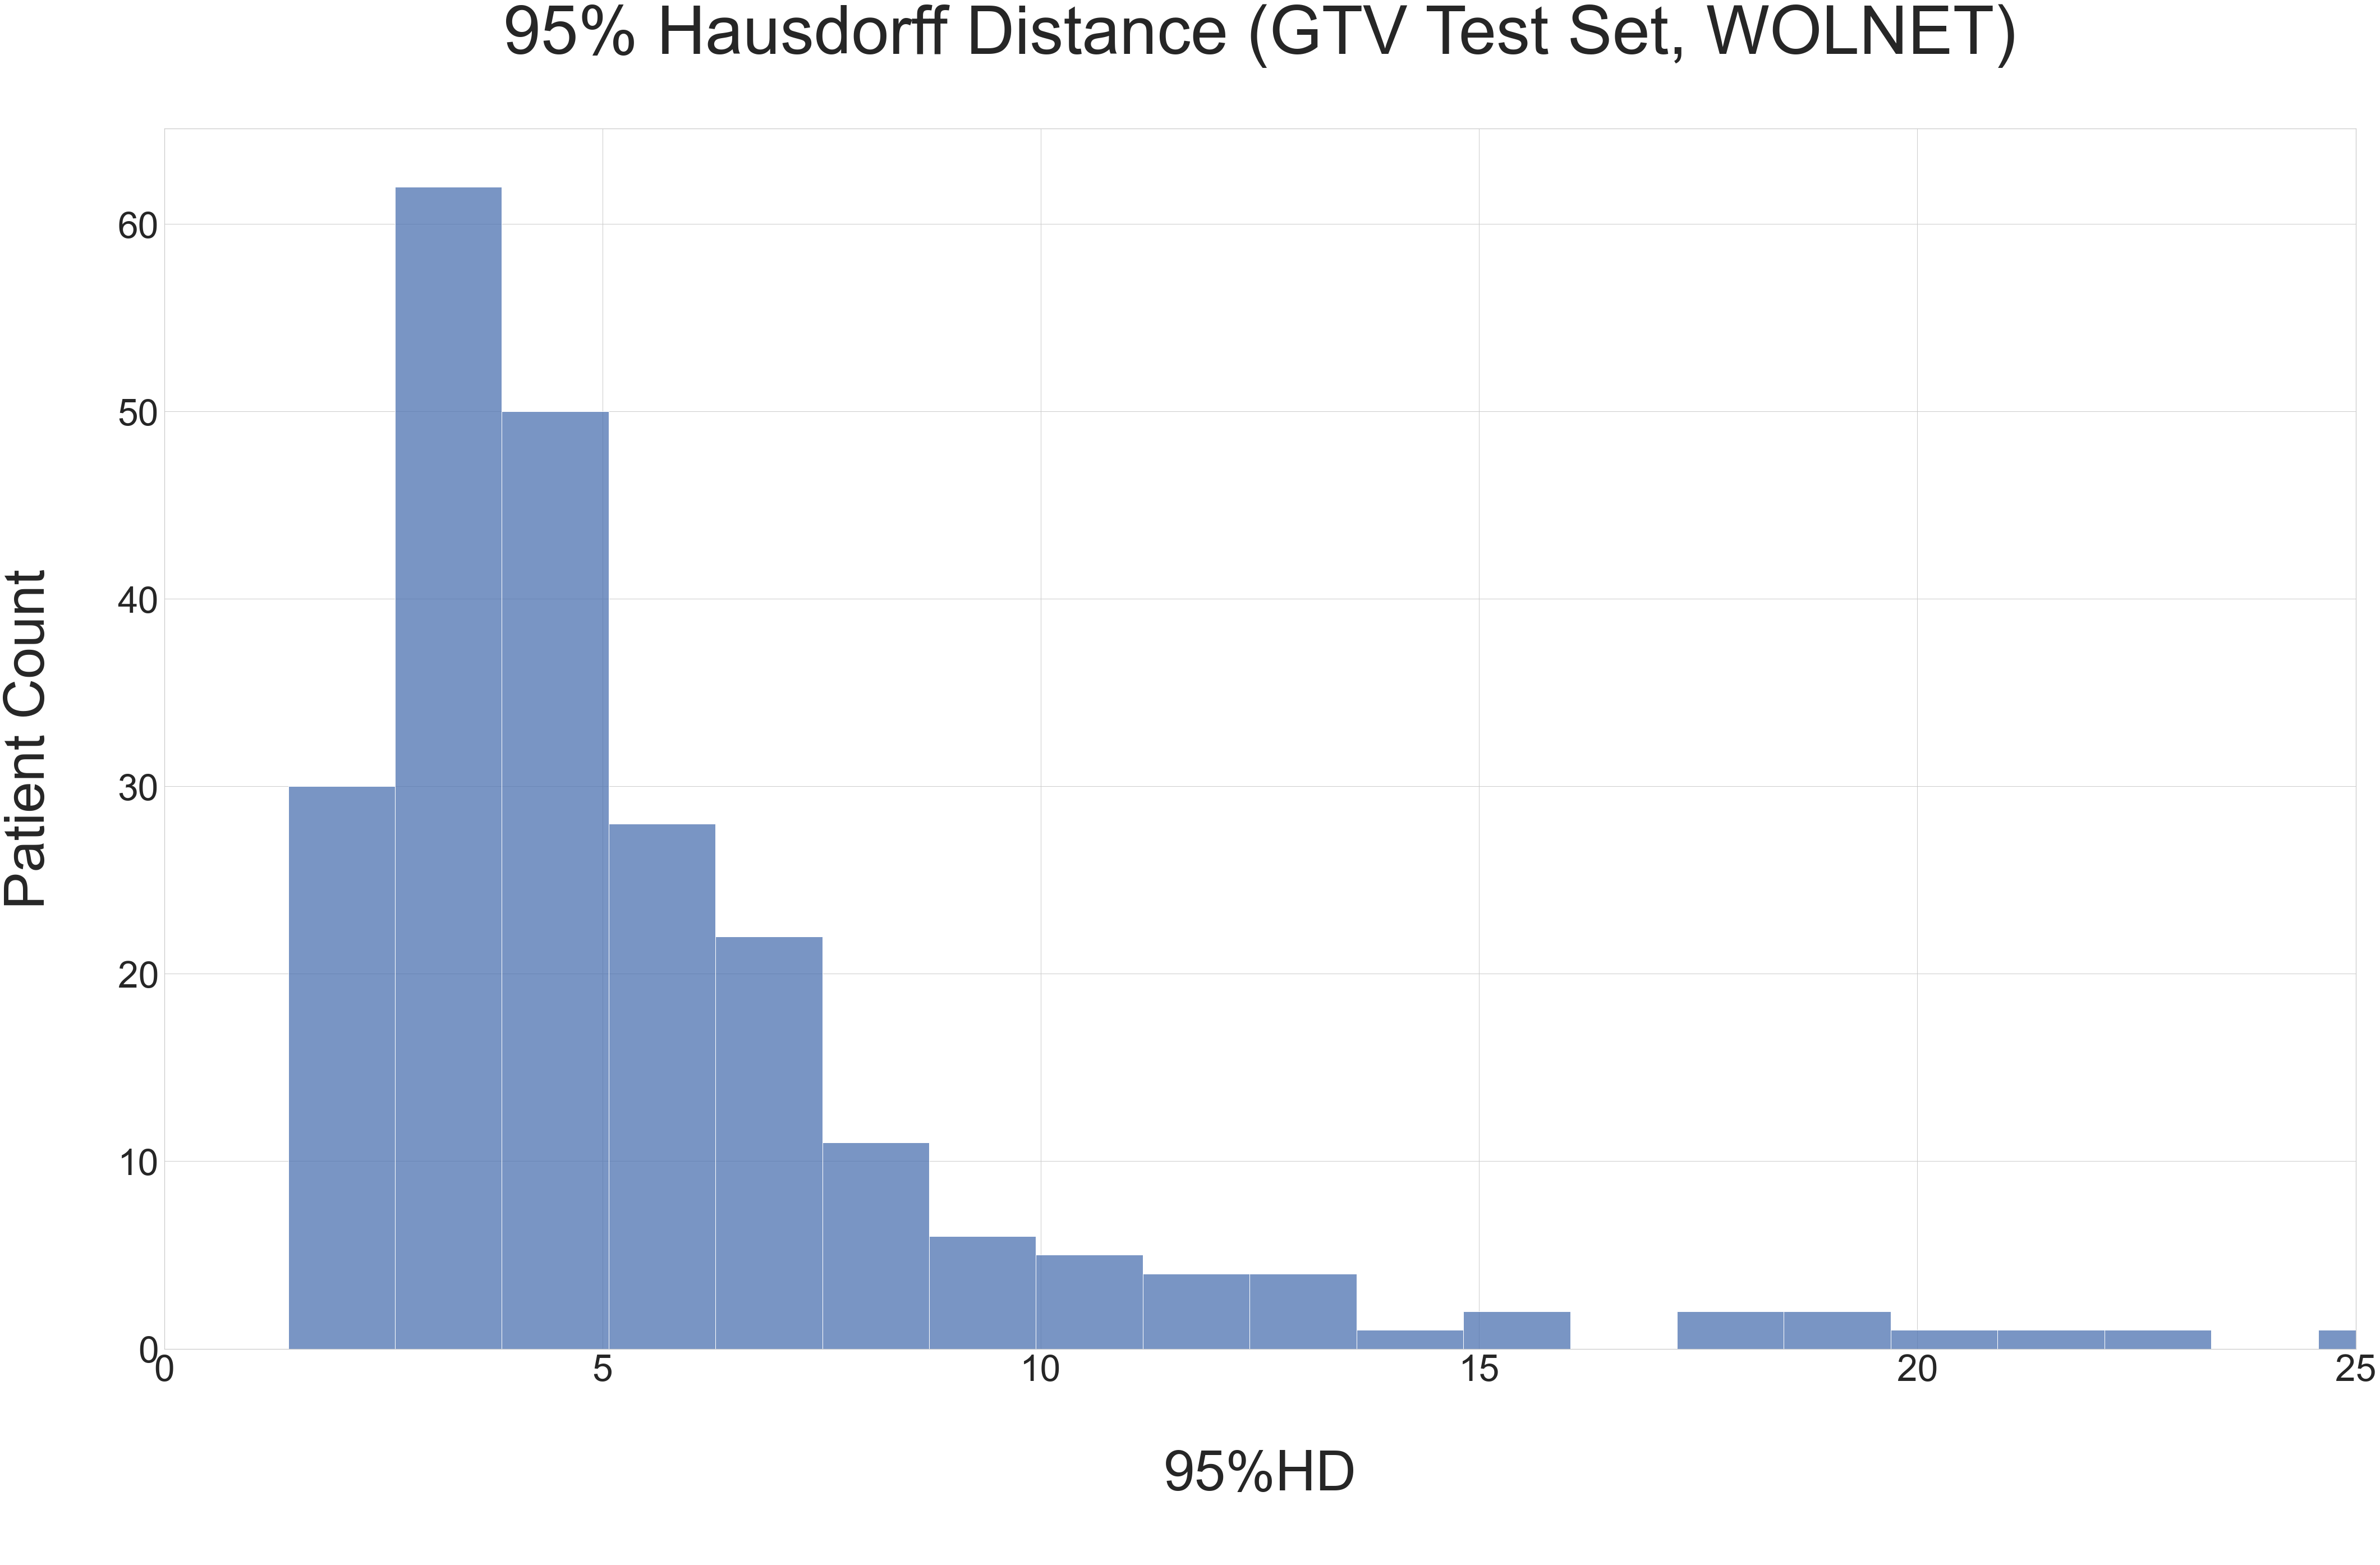

In [106]:
plt.figure(figsize=(70,40))
sea.set(font_scale=6)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
h = hd.numpy()
ax = sea.histplot(h[h<100])
plt.title('95% Hausdorff Distance (GTV Test Set, WOLNET)\n', fontsize=120)
ax.set_xlabel('\n95%HD\n', fontsize=100)
ax.set_ylabel('Patient Count\n', fontsize=100)
ax.set_xlim(0, 25)
ax.legend_.remove()

<AxesSubplot:ylabel='Count'>

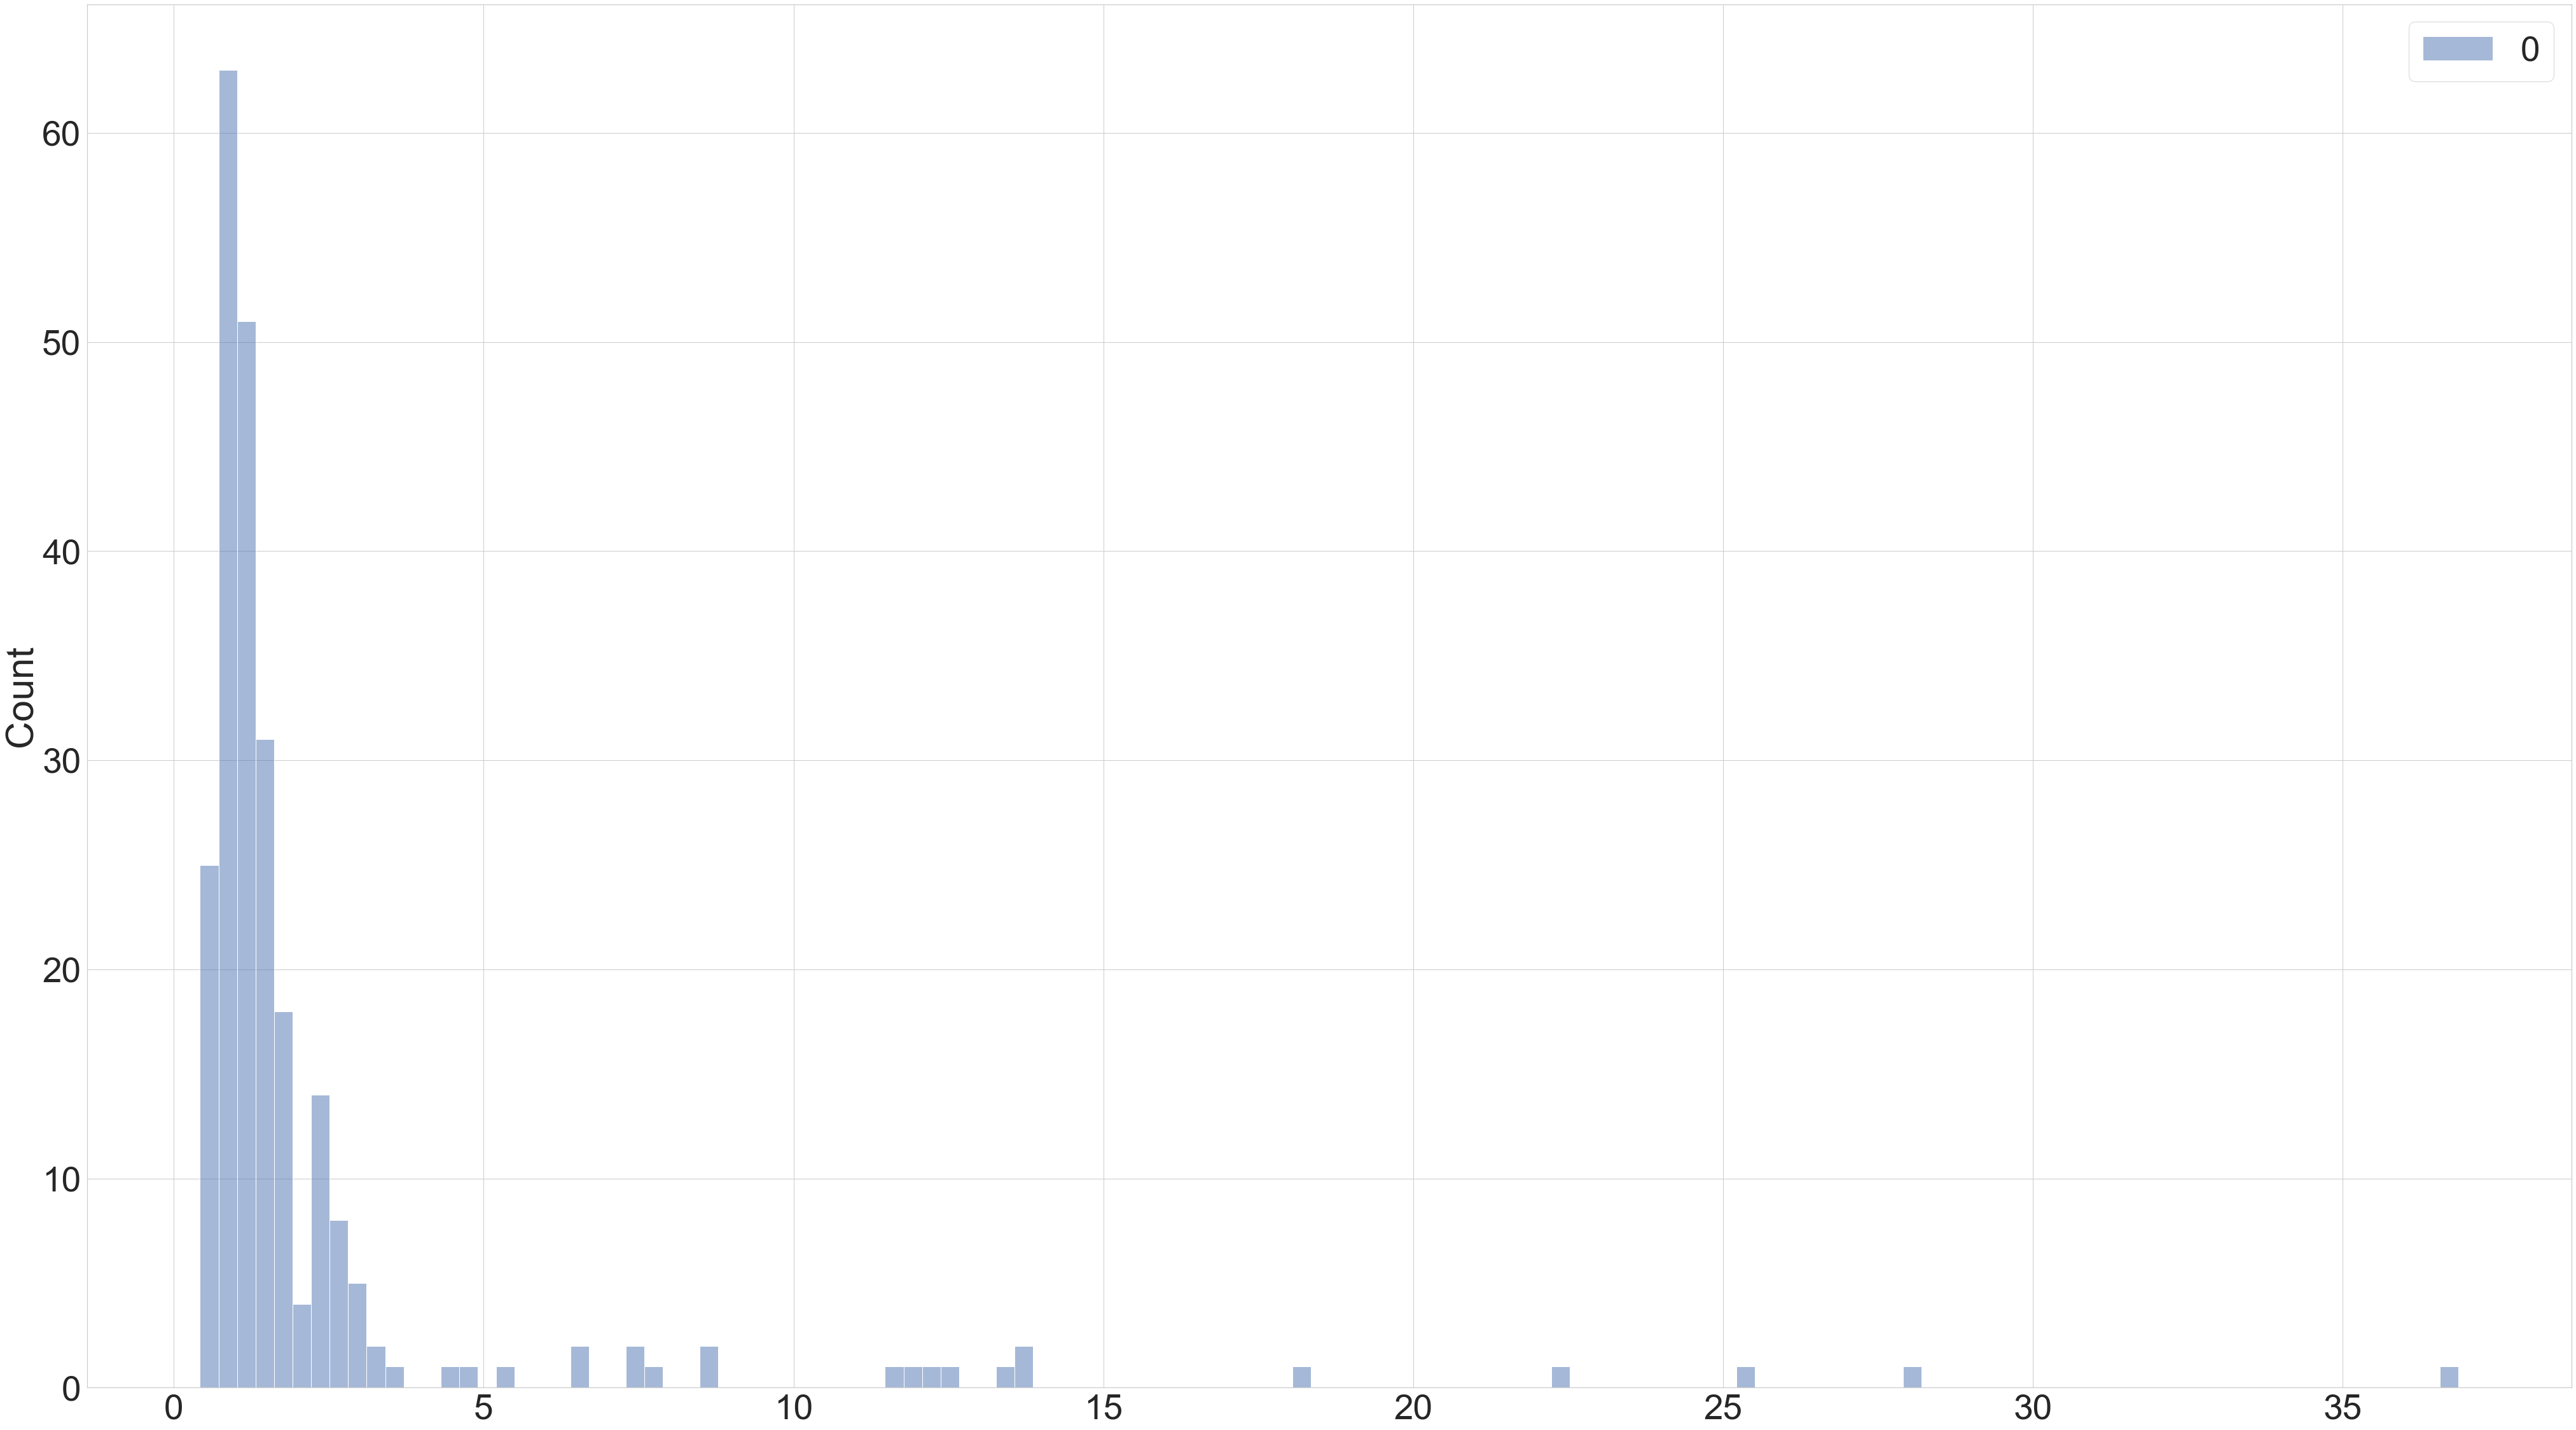

In [61]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
sea.histplot(sd.numpy())

In [110]:
print(dce[dce>0].median(), dce[dce>0].std())

tensor(0.7398) tensor(0.1584)


In [109]:
print(hd[hd<100].median(), hd[hd<100].std())

tensor(4.4721, dtype=torch.float64) tensor(7.6349, dtype=torch.float64)


In [85]:
img = image[175][0]
ta = targ[175][0]
ou = out[175][0]

0
1
2
3
4
5


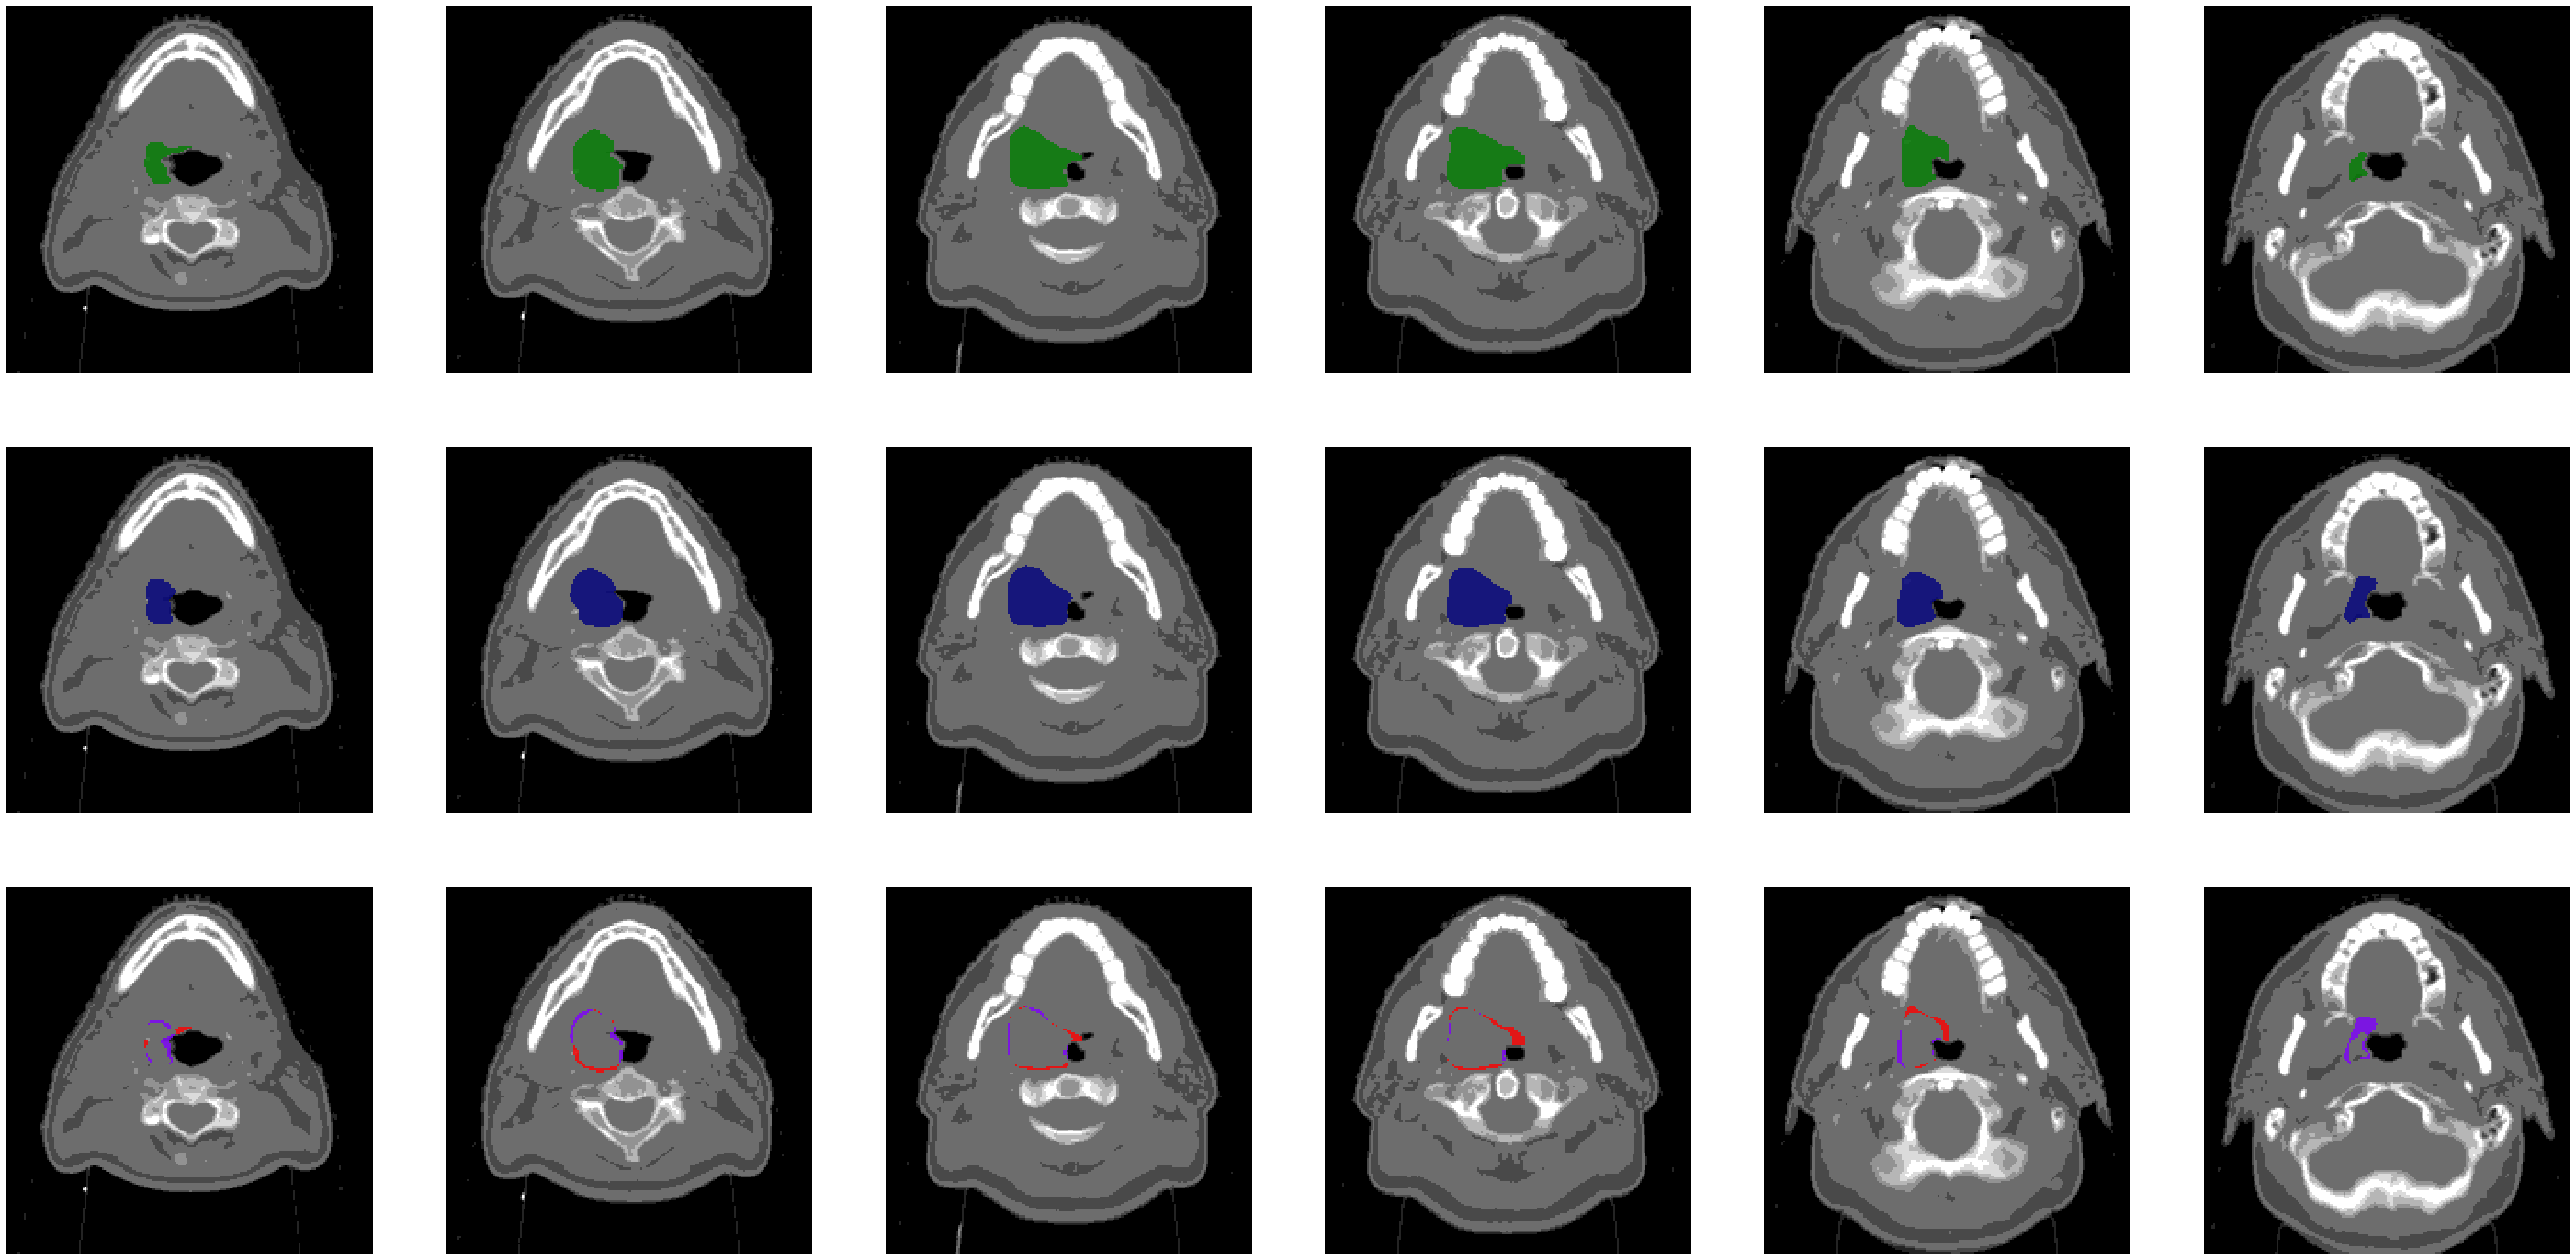

In [95]:
slices = [24, 28, 32, 34, 38, 40]
fig = plt.figure(figsize=(50,25))
for i, val in enumerate(slices):
    
    slice_ = img[val]

    ax1 = fig.add_subplot(3,6,1+i)
    targ_ = np.round(ta[val])
    targed = np.ma.masked_where(targ_ == 0, targ_)
    ax1.imshow(np.round(slice_), cmap='gray', interpolation='none')
    ax1.imshow(targed*2, alpha=0.8, cmap='ocean', interpolation='none')
    # ax1.set_title("Ground Truth")
    ax1.axis('off')

    ax2 = fig.add_subplot(3,6,7+i)
    out_ = np.round(ou[val])
    outed = np.ma.masked_where(out_ == 0, out_)
    ax2.imshow(np.round(slice_), cmap='gray', interpolation='none')
    ax2.imshow(outed*3, alpha=0.8, cmap='jet', interpolation='none')
    # ax2.set_title("Prediction")
    ax2.axis('off')

    ax3 = fig.add_subplot(3,6,13+i)
    diff = np.round(targ_ - out_)
    diffed = np.ma.masked_where(diff == 0, diff)
    ax3.imshow(np.round(slice_), cmap='gray', interpolation='none')
    ax3.imshow(diffed*4, alpha=0.8, cmap='rainbow', interpolation='none')
    # ax3.set_title("Difference")
    ax3.axis('off')
    print(i)
    # fig.savefig(f'/Users/josephmarsilla/SegmentHN/paper/55/{i}.png')

plt.show()

In [86]:
for i, v in enumerate(ta):
    if v.max()>0:
        print(i)

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [89]:
np.round(slice_)*3

array([[-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.]], dtype=float32)